In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import utils
import stock_data_fetcher
from stock_plotter import StockPlotter
from models import Models
from model_evaluator import ModelEvaluator
from time_series_visualizer import TimeSeriesVisualizer
from transformer_model import TimeSeriesTransformer
from lstm_transformer_model import LSTMTransformer
from backtest import BacktestStrategy

from matplotlib.backends.backend_pdf import PdfPages

# from csv file
stock_data = pd.read_csv("uber.csv")
print(stock_data.head())
ticker = "uber(csv)" 
print(ticker)

[*********************100%***********************]  1 of 1 completed


Index(['Close', 'High', 'Low', 'Open', 'Volume', 'RSI', 'MACD', 'Signal',
       'BB_upper', 'BB_middle', 'BB_lower'],
      dtype='object')


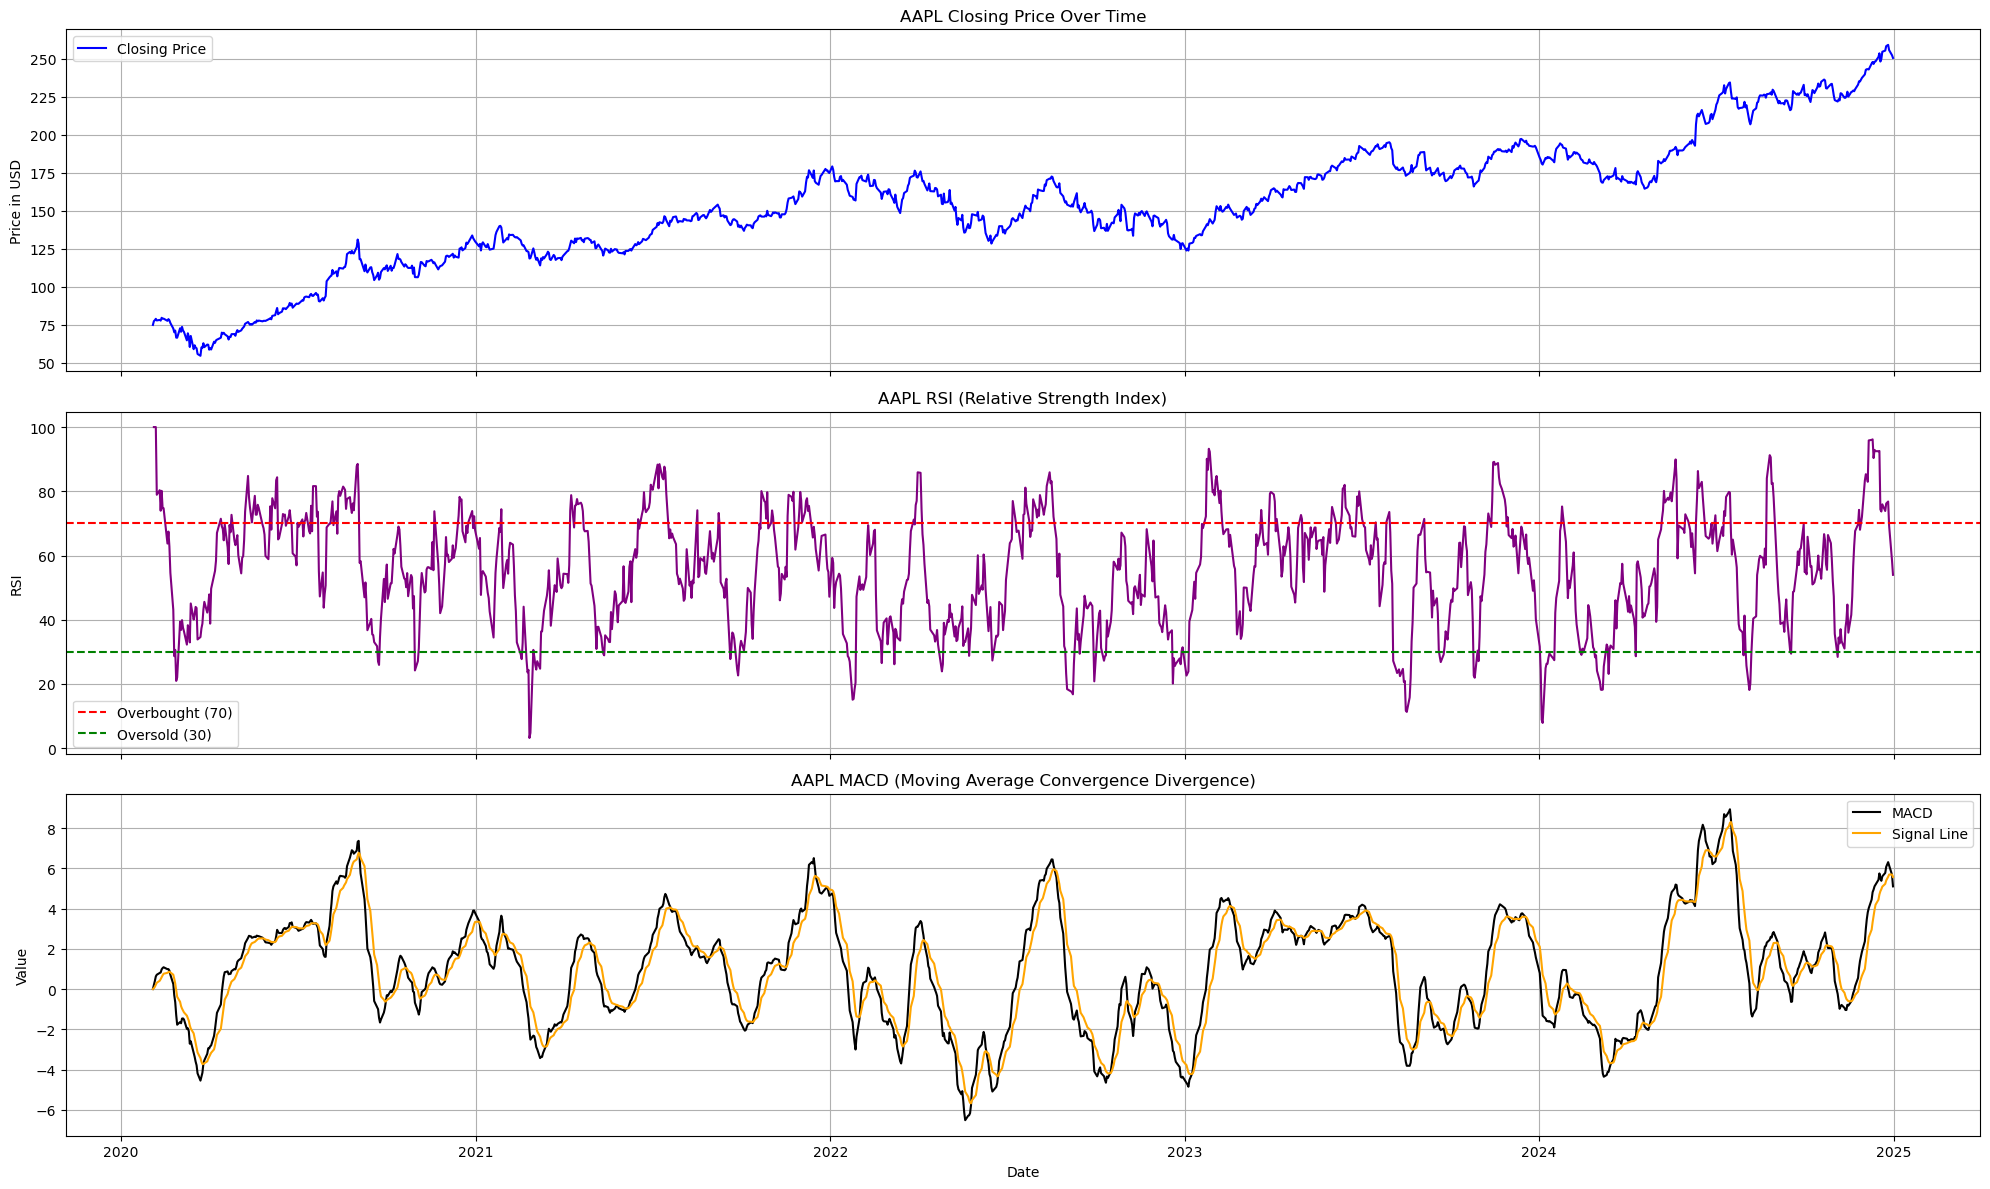

In [2]:
ticker = "AAPL"
start = "2020-02-01"
end = "2025-01-01"
interval = "1d"
pdf_path = f"results/results_{ticker}_{start}_to_{end}.pdf"

pdf_pages = PdfPages(pdf_path)

stock_fetcher = stock_data_fetcher.StockDataFetcher(ticker, start, end, interval)
stock_data = stock_fetcher.fetch_data()

df = utils.add_technical_indicators(stock_data)

df_scaled, scaler = utils.prepare_features(df)
sequence_length = 15
X, y = utils.create_sequences(df_scaled[19:], sequence_length)

train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

X_train = np.array(X_train, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)

X_train, y_train = utils.augment_data(X_train, y_train)

plotter = StockPlotter(stock_data, ticker)
fig1 = plotter.plot()
pdf_pages.savefig(fig1)  # Save stock plot to PDF

In [3]:
n_features = X_train.shape[2]
lstm_model = Models.LSTM_Model(sequence_length, n_features)
best_params = lstm_model.tune_hyperparameters(X_train, y_train)
history = lstm_model.fit(X_train, y_train, epochs=40, batch_size=32, validation_split=0.1)
y_pred_lstm = lstm_model.predict(X_test).flatten()

Reloading Tuner from lstm_tuner\lstm_hyperparameter_tuning\tuner0.json
Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.0613 - val_loss: 0.0248
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0335 - val_loss: 0.0244
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0445 - val_loss: 0.0228
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0373 - val_loss: 0.0214
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0282 - val_loss: 0.0230
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0348 - val_loss: 0.0209
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0275 - val_loss: 0.0202
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0312 - val_loss: 0.0212
Epoch 9/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0277 - val_loss: 0.0205
Epoch 10/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0271 - val_loss: 0.0202
Epoch 1/40
163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0384 

xgb_model = Models.XGB_Model(n_estimators=150, max_depth=8, learning_rate=0.05, gamma=0.3, subsample=0.9)
xgb_model.summary()
xgb_model.fit(X_train, y_train)
predictions = xgb_model.predict(X_test)
y_pred_xgb = predictions.flatten()
##print(type(y_pred_xgb))
print(y_pred_xgb)

gp_model = Models.GP_Model()
gp_model.fit(X_train, y_train)

# Predict with confidence intervals
y_pred_gp, sigma_gp = gp_model.predict(X_test, return_std=True)

# Print predictions and standard deviation (sigma)
##print("Type of y_pred_gp:", type(y_pred_gp))
##print("Predictions:", y_pred_gp)
##print("Sigma (Uncertainty):", sigma_gp)

# Define input feature size dynamically from X_train
input_feature_size = X_train.shape[-1]  # Extracts the number of features

transformer_model = LSTMTransformer(
    num_layers=4,
    d_model=input_feature_size,  # Set `d_model` to the number of input features
    num_heads=8,
    dff=512,
    input_seq_len=20
)

projection_layer = tf.keras.layers.Dense(input_feature_size)  # Use `input_feature_size`
X_test_transformed = projection_layer(X_test)

y_pred_transformer = transformer_model(X_test_transformed)

print("Predicted Output Shape:", y_pred_transformer.shape)  # Expected: (10, 1)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Model: LSTM1
MSE: 0.6569
MAE: 0.6624
R²: 0.8202
Direction: 0.5095
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


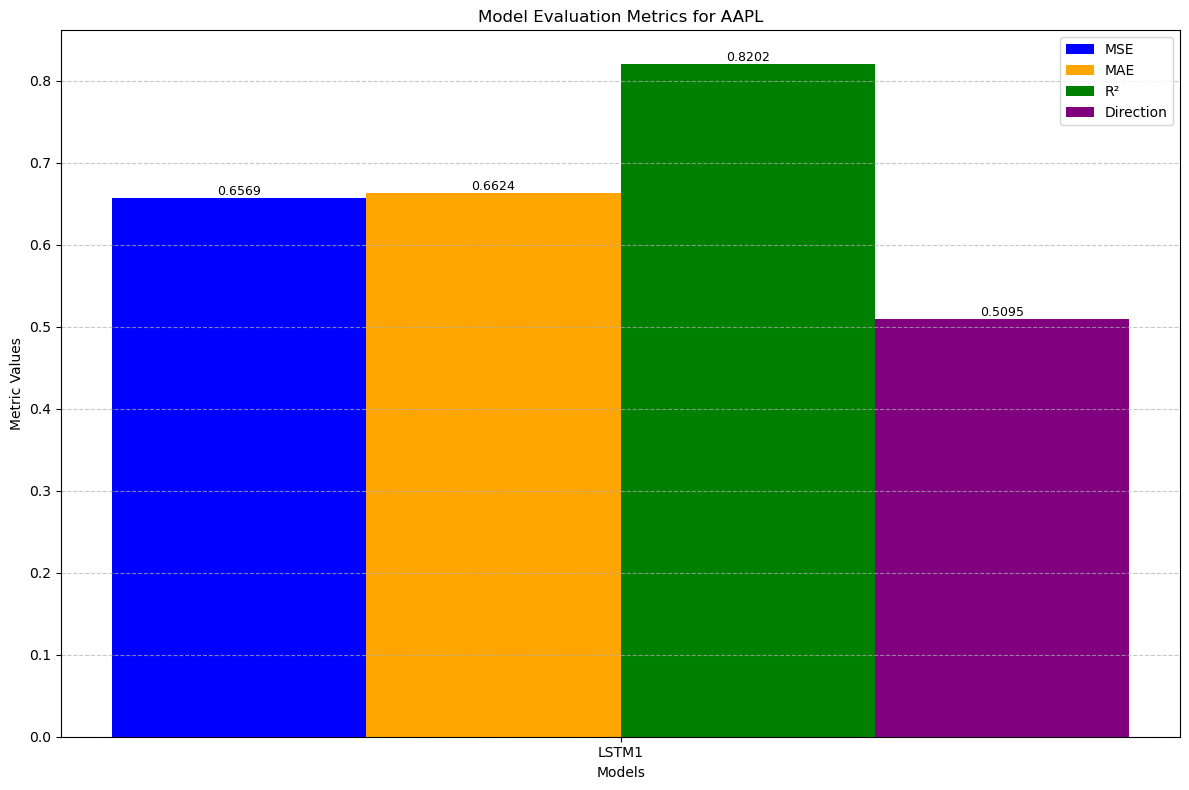

In [4]:
models = {
    'LSTM1': lstm_model,
    #'LSTM2': lstm_model  # Duplicate model with different names
}
evaluator = ModelEvaluator(models, X_test, y_test, ticker)

# Evaluate models
evaluation_results, y_predictions = evaluator.evaluate()

# Print results
for model, metrics in evaluation_results.items():
    print(f"\nModel: {model}")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

fig2 = evaluator.plot_metrics()
pdf_pages.savefig(fig2)

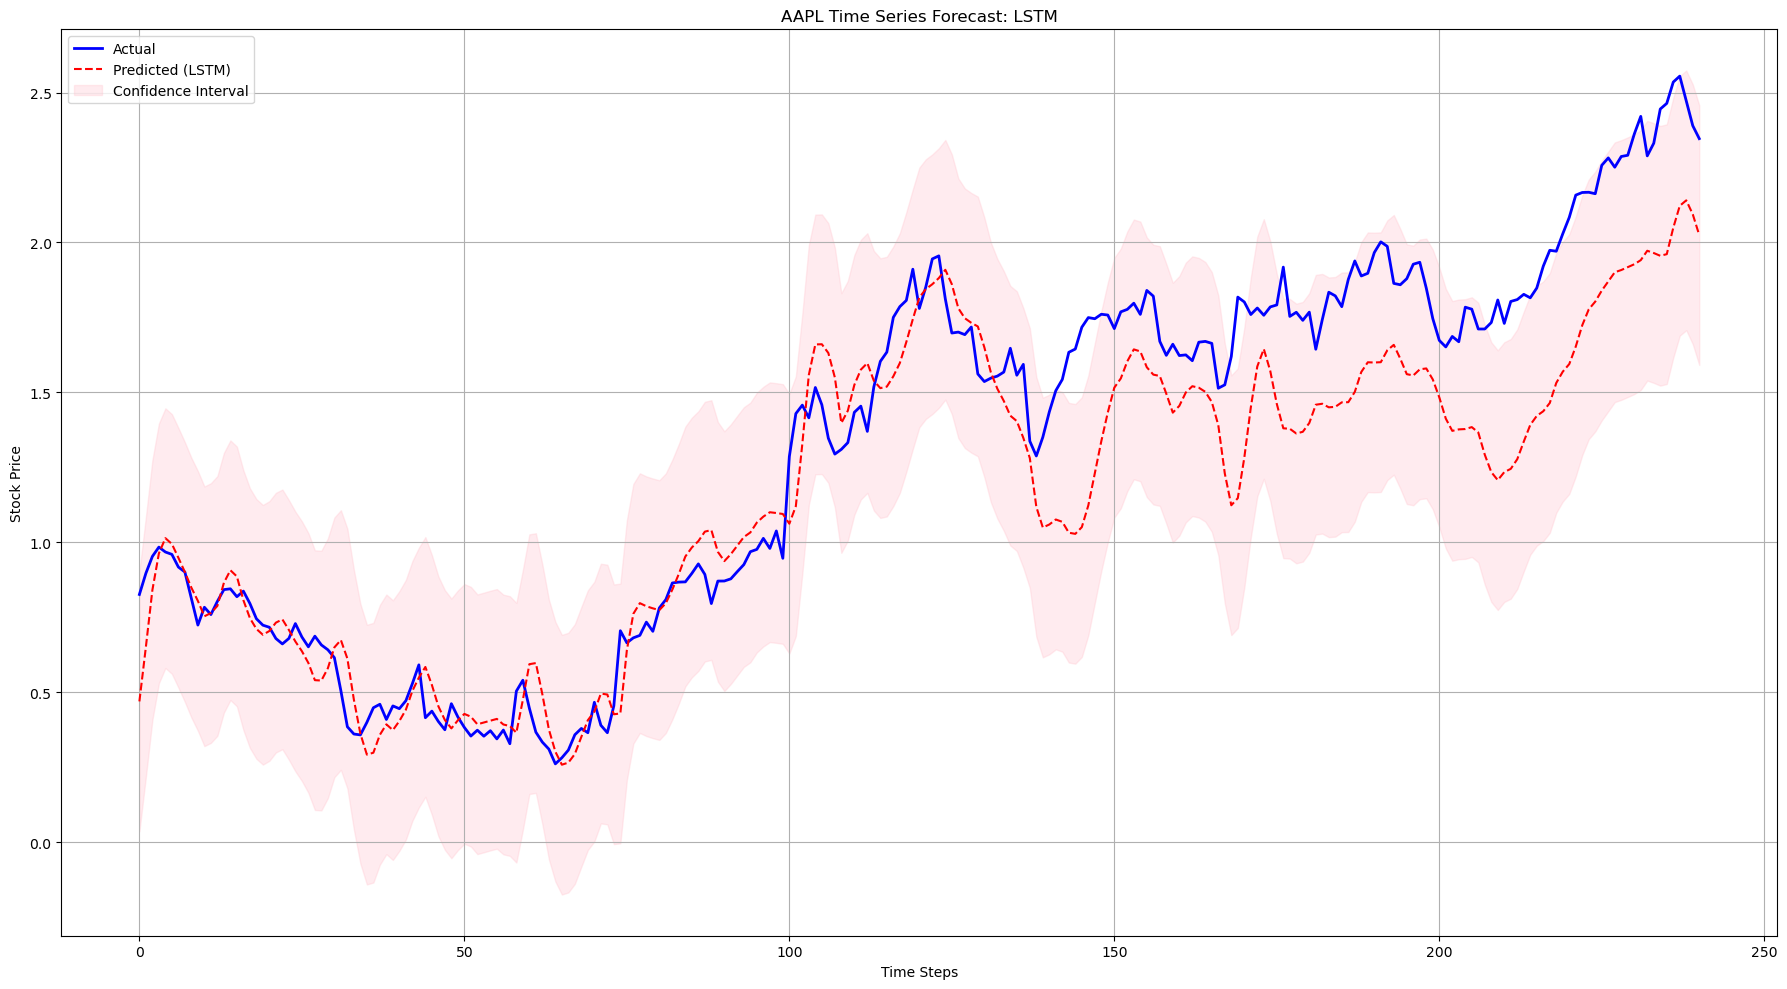

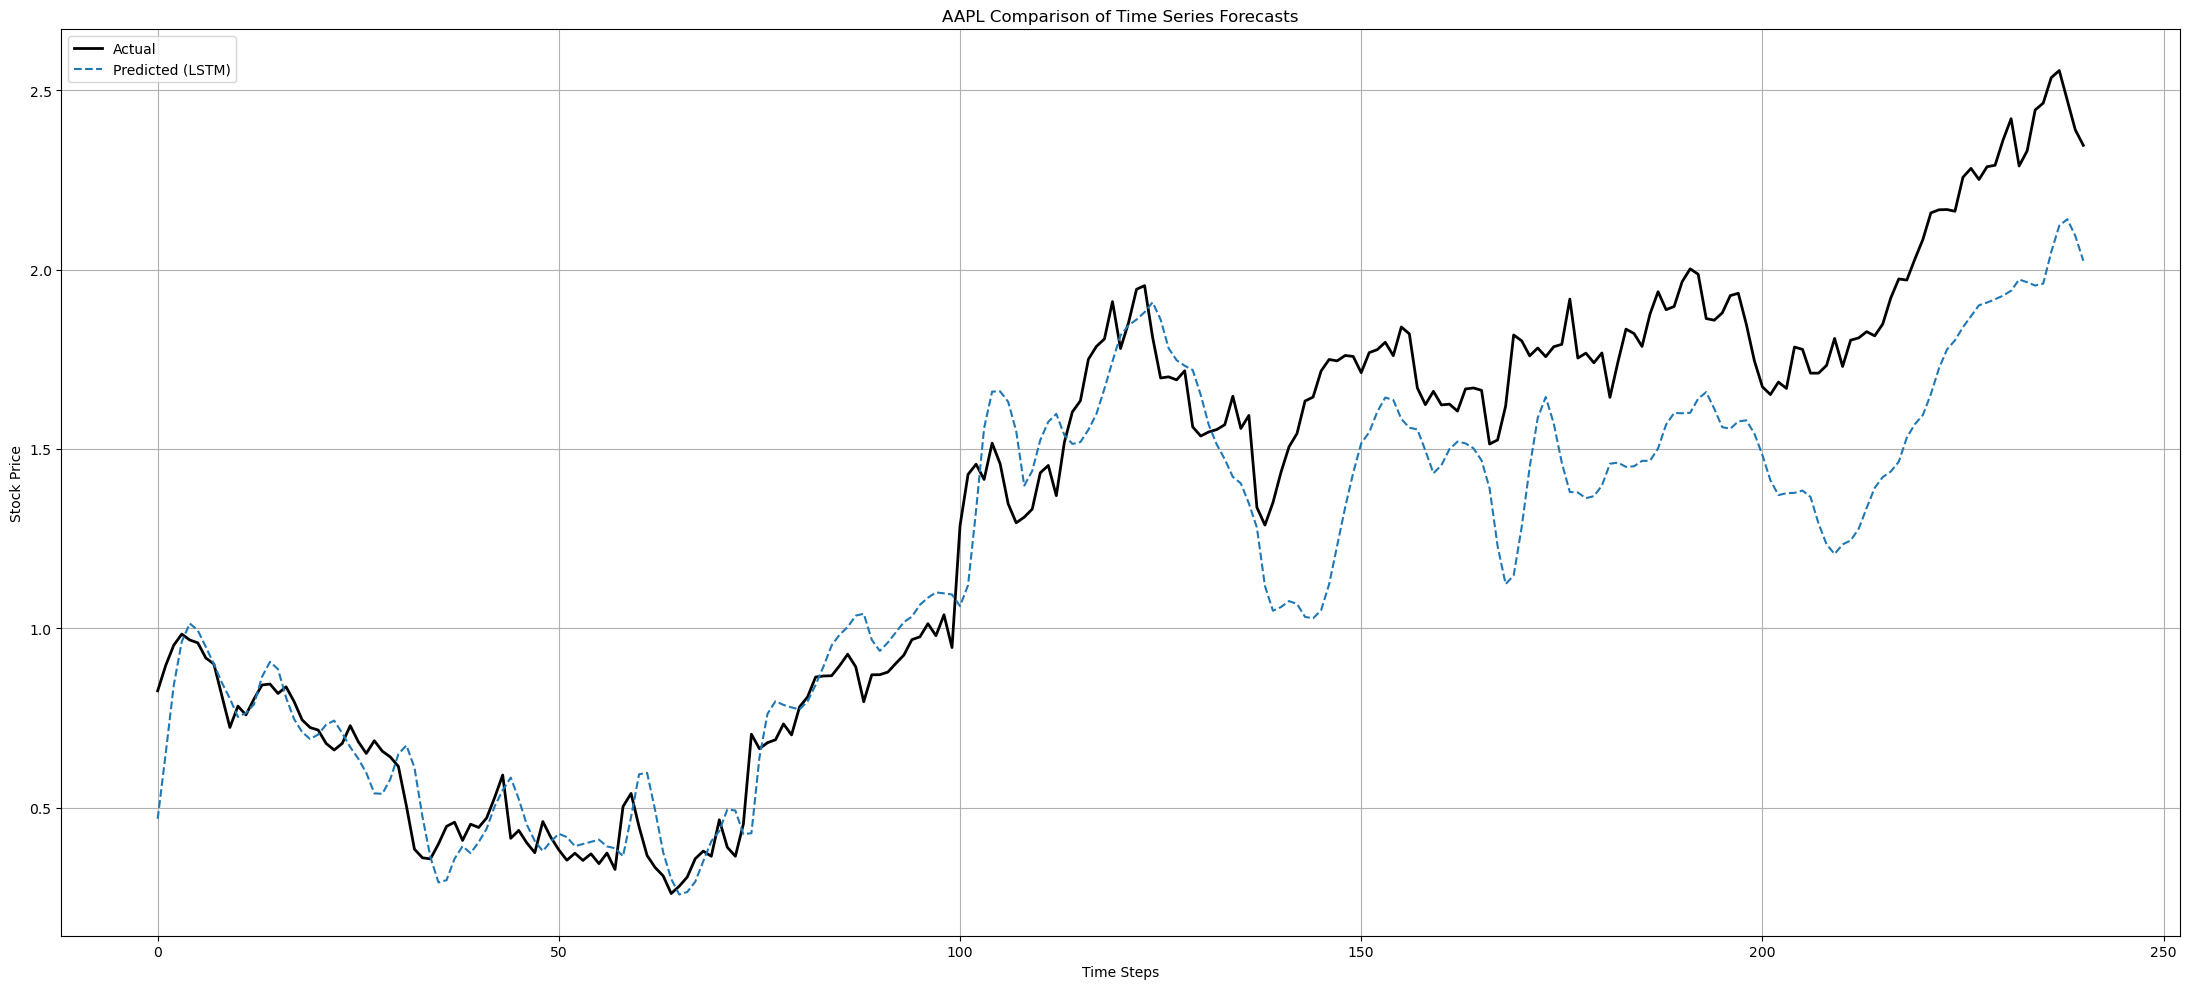

In [5]:
std_devs = {}  # Ensure std_devs exists even if sigma_gp is not available

if 'sigma_gp' in globals():
    std_devs['GP'] = sigma_gp  # Add Gaussian Process std deviation if available# Assuming you have predictions from LSTM, XGBoost, and Gaussian Process
    
'''predictions = {
    'LSTM': y_pred_lstm,
    'XGBoost': y_pred_xgb,
    'GP': y_pred_gp,
    'Transformer': y_pred_transformer
}'''
predictions = {
    'LSTM': y_pred_lstm
}
if 'sigma_gp' in globals():
    std_devs = {'GP': sigma_gp}

visualizer = TimeSeriesVisualizer(y_test, predictions, ticker, std_devs)

fig3 = visualizer.plot_predictions()
pdf_pages.savefig(fig3)
fig4 = visualizer.compare_models()
pdf_pages.savefig(fig4)

Backtest for LSTM completed. Final balance: $23143.74

Performance Metrics:
Final Balance: 23143.7442
Total Return: 1.3144
Sharpe Ratio: 0.0858
Max Drawdown: 0.3314


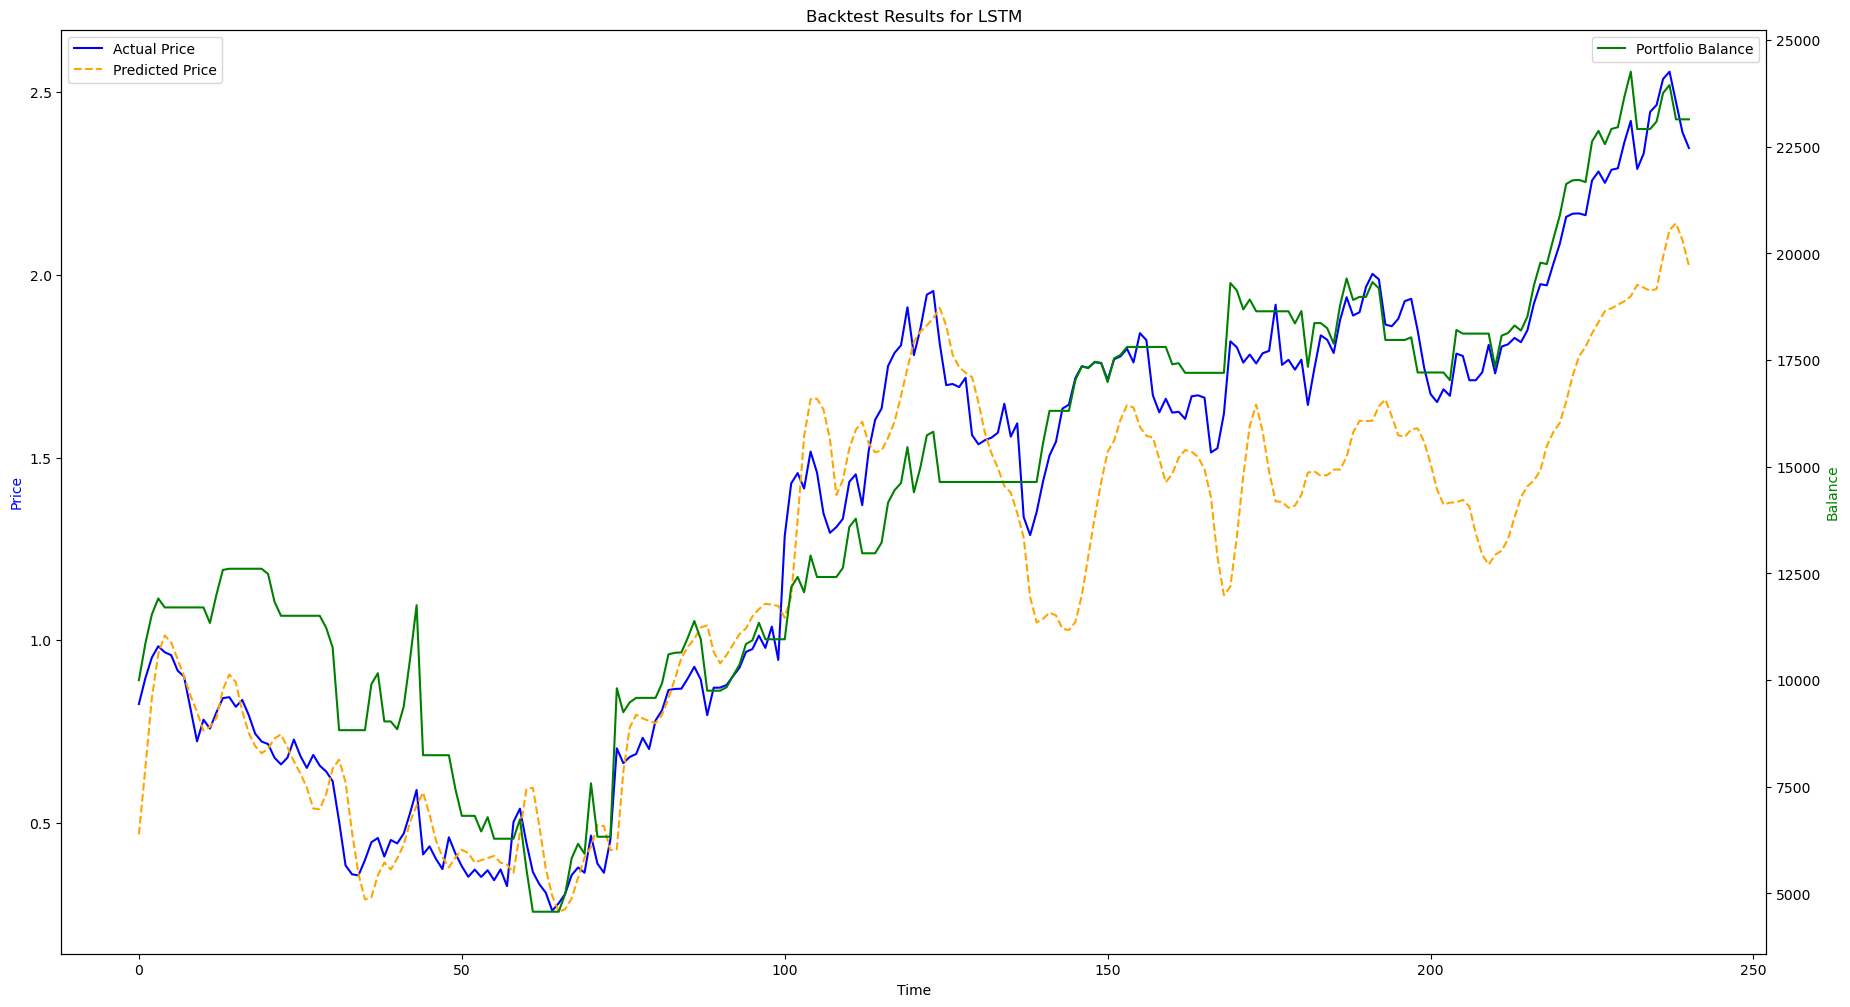

PDF successfully saved in: results/results_AAPL_2020-02-01_to_2025-01-01.pdf


In [6]:

backtester = BacktestStrategy(initial_balance=10000, transaction_cost=0.001)

results_lstm = backtester.backtest(y_test, y_pred_lstm, model_name="LSTM")
metrics_lstm = backtester.evaluate_performance(results_lstm)

fig5 = backtester.plot_results(results_lstm, model_name="LSTM")  
pdf_pages.savefig(fig5)

# results_xgb = backtester.backtest(y_test, y_pred_xgb, model_name="XGBoost")
# metrics_xgb = backtester.evaluate_performance(results_xgb)
# fig4 = backtester.plot_results(results_xgb, model_name="XGBoost")
# pdf_pages.savefig(fig4)
# print("Backtest results for XGBoost saved to PDF (Page 4).")

pdf_pages.close()
print(f"PDF successfully saved in: {pdf_path}")

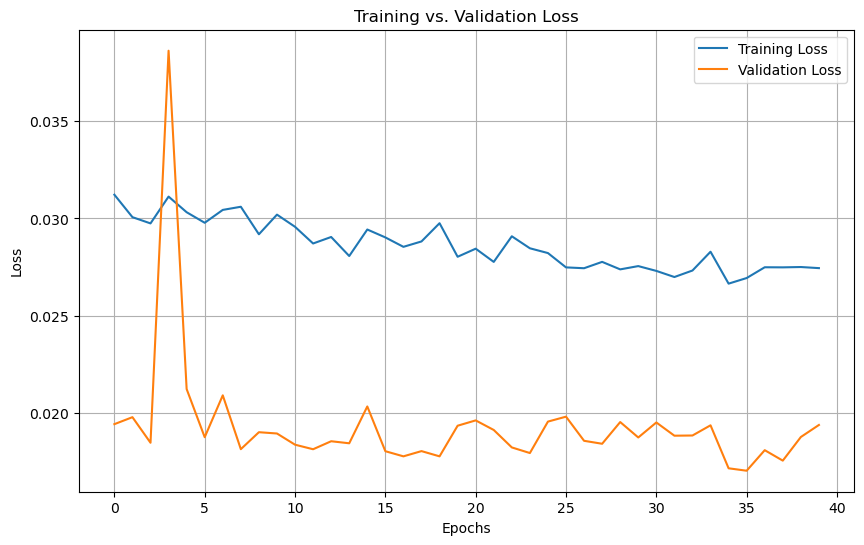

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()